In [28]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os
import logging

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf

logging.getLogger('tensorflow').setLevel(logging.ERROR)  # suppress warnings
# connect to TPU
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='local')
tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)
strategy = tf.distribute.TPUStrategy(resolver)

In [ ]:
images = []

for file_name in os.listdir('images'):
    if file_name.endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
        image_path = os.path.join('images', file_name)
        image = Image.open(image_path)
        image = image.resize((1024, 576))
        images.append(image)



new_images = []
for i in images:
    new_images.append(np.array(i))

new_images = np.array(new_images)

In [ ]:
low_quality = tf.image.resize(new_images, [50, 50])
low_quality = tf.image.resize(low_quality, [256, 256])

In [ ]:
def save_images_to_folder(images, output_folder):

    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for idx, img in enumerate(images):
        output_path = os.path.join(output_folder, f"{idx}.jpg")
        img.save(output_path)
        print(f"Saved {output_path}")

low_quality = [Image.fromarray((img).astype(np.uint8)) for img in low_quality]
save_images_to_folder(low_quality, 'new_images')

Found 3670 files belonging to 5 classes.


tcmalloc: large alloc 2886205440 bytes == 0x144d6a000 @  0x7f9d50808680 0x7f9d50829824 0x7f9d4620a994 0x7f9d4620b12f 0x7f9d462698f5 0x7f9d4626cb1a 0x7f9d4626d017 0x7f9d4630a255 0x5c4dd7 0x570556 0x5697da 0x68e547 0x601624 0x5c4ef0 0x56b4ed 0x5009c8 0x56cefd 0x5009c8 0x56cefd 0x5009c8 0x504716 0x56b619 0x5f6ce6 0x56b4ed 0x5f6ce6 0x56b619 0x5697da 0x5f6ec3 0x50b17c 0x5f60b2 0x56ccfc
tcmalloc: large alloc 2886205440 bytes == 0x1f0dea000 @  0x7f9d50808680 0x7f9d50829824 0x7f9d4620a994 0x7f9d4620b12f 0x7f9d462698f5 0x7f9d46269a56 0x7f9d4648038c 0x7f9d46488f3e 0x5f40f1 0x5f43b5 0x7f9d46324e0c 0x50ed6c 0x56cbf4 0x5697da 0x68e547 0x601624 0x5c4ef0 0x56b4ed 0x5009c8 0x56cefd 0x5009c8 0x56cefd 0x5009c8 0x504716 0x56b619 0x5f6ce6 0x56b4ed 0x5f6ce6 0x56b619 0x5697da 0x5f6ec3
tcmalloc: large alloc 2886205440 bytes == 0x144d6a000 @  0x7f9d50808680 0x7f9d50829824 0x7f9d50829b8a 0x7f9ca21fdbd4 0x7f9ca2cb2b75 0x7f9ca2d5baed 0x7f9ca2b8160e 0x7f9ca2b821fe 0x7f9ca2b82409 0x7f9c8f104184 0x7f9ca2e28b6d 0x7f

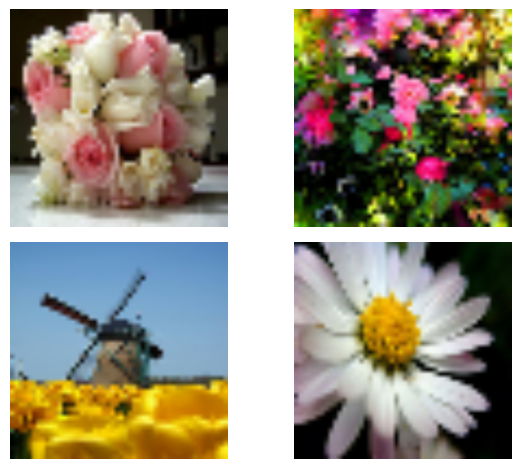

In [2]:
data_dir = "flower_photos"
train_ds = tf.keras.utils.image_dataset_from_directory(data_dir, seed=123, image_size=(256, 256), batch_size=1)
original_array = []
for index, i in enumerate(train_ds):
    if index < 10000:
        original_array.append(i[0][0])
original_array = np.array(original_array)
original_array = (original_array) / 255.

low_quality = tf.image.resize(original_array, [50, 50])
low_quality = tf.image.resize(low_quality, [256, 256])
low_quality = np.array(low_quality)

plt.figure()
for row in range(2):
    for col in range(2):
        index = row * 2 + col
        plt.subplot(2, 2, index + 1)
        plt.imshow(low_quality[index])
        plt.axis("off")
plt.tight_layout()
plt.show()
plt.close()

In [18]:
with strategy.scope():

    input = tf.keras.layers.Input(shape=(256, 256, 3))
    
    # Encoder
    x = tf.keras.layers.Conv2D(256, (3, 3), activation="relu", padding="same")(input)
    x = tf.keras.layers.MaxPooling2D((2, 2), padding="same")(x)
    x = tf.keras.layers.Conv2D(256, (3, 3), activation="relu", padding="same")(x)
    x = tf.keras.layers.MaxPooling2D((2, 2), padding="same")(x)
    
    # Decoder
    x = tf.keras.layers.Conv2DTranspose(256, (3, 3), strides=2, activation="relu", padding="same")(x)
    x = tf.keras.layers.Conv2DTranspose(256, (3, 3), strides=2, activation="relu", padding="same")(x)
    x = tf.keras.layers.Conv2D(3, (3, 3), activation="sigmoid", padding="same")(x)
    
    # Autoencoder
    autoencoder = tf.keras.models.Model(input, x)
    optimizer = tf.keras.optimizers.Adam(1e-5)
    autoencoder.compile(optimizer=optimizer, loss="mse")
    
    autoencoder.fit(x=low_quality[10:], y=original_array[10:], batch_size=128, epochs=10)

Epoch 1/10
29/29 [==============================] - 9s 157ms/step - loss: 0.0071
Epoch 2/10
29/29 [==============================] - 5s 157ms/step - loss: 0.0071
Epoch 3/10
29/29 [==============================] - 5s 157ms/step - loss: 0.0071
Epoch 4/10
29/29 [==============================] - 5s 157ms/step - loss: 0.0071
Epoch 5/10
29/29 [==============================] - 5s 157ms/step - loss: 0.0071
Epoch 6/10
29/29 [==============================] - 5s 162ms/step - loss: 0.0071
Epoch 7/10
29/29 [==============================] - 5s 157ms/step - loss: 0.0071
Epoch 8/10
29/29 [==============================] - 5s 155ms/step - loss: 0.0071
Epoch 9/10
29/29 [==============================] - 5s 157ms/step - loss: 0.0071
Epoch 10/10
29/29 [==============================] - 4s 152ms/step - loss: 0.0071


1/1 [==============================] - 2s 2s/step


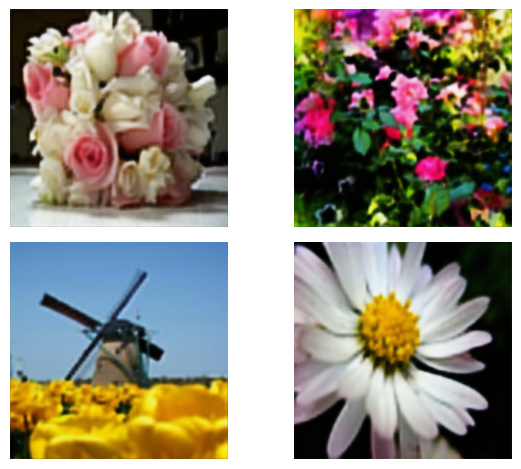

In [27]:
pred = autoencoder.predict(original_array[:4])
for row in range(2):
    for col in range(2):
        index = row * 2 + col
        plt.subplot(2, 2, index + 1)
        plt.imshow(pred[index])
        plt.axis("off")
plt.tight_layout()
plt.show()
plt.close()